In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import classification_report, mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_submissions():
    !kaggle competitions submissions playground-series-s3e11

In [4]:
def push_kaggle(filename):
    !kaggle competitions submit -c playground-series-s3e11 -f {filename} -m ""

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [7]:
train.drop(['id'], axis=1, inplace=True)

In [8]:
test.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
1,360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
2,360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
3,360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
4,360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


<Axes: >

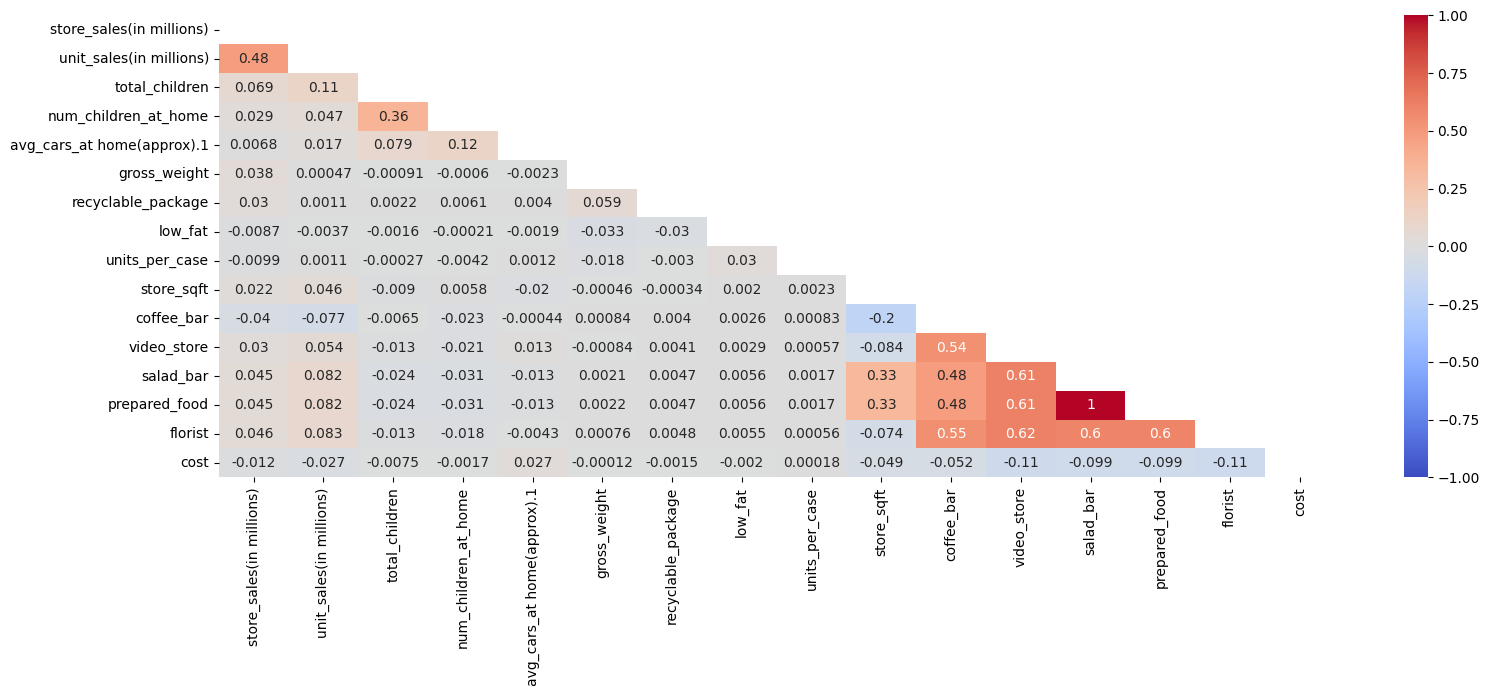

In [9]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [30]:
X_train = train.drop(['cost', 'prepared_food'], axis=1)
y_train = train[['cost']]
X_test = test.drop(['id', 'prepared_food'], axis=1)

In [31]:
for df in [X_train, X_test]:
    df['ratio'] = df.eval('total_children / num_children_at_home')
    df.replace([np.inf, -np.inf], 10, inplace = True)
    df.fillna(0, inplace = True)
    df['facilities'] = df.eval('coffee_bar + video_store + salad_bar + florist')
    df['independent_kid'] = df.eval('total_children - num_children_at_home')

In [32]:
y_train = np.log1p(y_train)

In [13]:
k = KFold(n_splits=5, random_state=0, shuffle=True)

In [14]:
def validate(model, X_train, y_train):
    train_scores, val_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(k.split(X_train, y_train)):
                
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        
        train_preds = model.predict(X_train.iloc[train_idx])
        val_preds = model.predict(X_train.iloc[val_idx])
        
        train_score = mean_squared_error(y_train.iloc[train_idx], train_preds, squared = False)
        val_score = mean_squared_error(y_train.iloc[val_idx], val_preds, squared = False)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        print(f'Fold {fold}: val RMSLE = {val_score:.5f} | train RMSLE = {train_score:.5f}')

    print(f'Average val RMSLE = {np.mean(val_scores):.5f} | train RMSLE = {np.mean(train_scores):.5f}')

In [19]:
print(f"Average MSE value: {abs(cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.313) total time=   0.1s
[CV] END ............................... score: (test=-0.314) total time=   0.1s
[CV] END ............................... score: (test=-0.313) total time=   0.1s
[CV] END ............................... score: (test=-0.315) total time=   0.1s
[CV] END ............................... score: (test=-0.313) total time=   0.1s
Average MSE value: 0.3133968501085837


In [20]:
print(f"Average MSE value: {abs(cross_val_score(Ridge(alpha=0.1, random_state=0), X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.313) total time=   0.1s
[CV] END ............................... score: (test=-0.314) total time=   0.1s
[CV] END ............................... score: (test=-0.313) total time=   0.1s
[CV] END ............................... score: (test=-0.315) total time=   0.1s
[CV] END ............................... score: (test=-0.313) total time=   0.1s
Average MSE value: 0.3133968500949983


In [21]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gaxgb_modelmma=0.1,
    colsample_bytree=1
)

print(f"Average MSE value: {abs(cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.295) total time=   3.9s
[CV] END ............................... score: (test=-0.297) total time=   4.0s
[CV] END ............................... score: (test=-0.296) total time=   3.8s
[CV] END ............................... score: (test=-0.297) total time=   3.8s
[CV] END ............................... score: (test=-0.296) total time=   4.0s
Average MSE value: 0.29637564662514854


In [28]:
params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **params
)

print(f"Average MSE value: {abs(cross_val_score(catboost_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.295) total time=   2.8s
[CV] END ............................... score: (test=-0.296) total time=   3.1s
[CV] END ............................... score: (test=-0.296) total time=   3.5s
[CV] END ............................... score: (test=-0.297) total time=   3.4s
[CV] END ............................... score: (test=-0.296) total time=   3.4s
Average MSE value: 0.29605880642321913


In [33]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
def generate_csv(model, X_train, y_train, X_test, filename, y_transformed = False):
    y_pred = model.fit(X_train, y_train).predict(X_test)
    output_df = test[['id']]
    if y_transformed:
        y_pred = np.expm1(y_pred)
    output_df['cost'] = y_pred
    output_df.to_csv(filename, index=False)
    print("Your submission was successfully saved!")

In [35]:
y_train.head()

,cost
0,4.144562
1,4.810557
2,4.436870
3,4.216267
4,4.723042


In [36]:
X_train_scaled

array([[0.36144578, 0.4       , 0.4       , ..., 0.1       , 0.        ,
        0.16666667],
       [0.20035698, 0.2       , 0.8       , ..., 1.        , 0.25      ,
        0.83333333],
       [0.60553324, 0.6       , 0.        , ..., 0.        , 0.25      ,
        0.16666667],
       ...,
       [0.45649264, 0.4       , 0.        , ..., 0.        , 1.        ,
        0.16666667],
       [0.46987952, 0.4       , 0.2       , ..., 1.        , 1.        ,
        0.33333333],
       [0.21374386, 0.2       , 0.4       , ..., 1.        , 0.75      ,
        0.5       ]])

In [37]:
model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=1
)

print(f"Average MSE value: {abs(cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.295) total time=   4.0s
[CV] END ............................... score: (test=-0.297) total time=   4.1s
[CV] END ............................... score: (test=-0.296) total time=   4.0s
[CV] END ............................... score: (test=-0.297) total time=   3.7s
[CV] END ............................... score: (test=-0.296) total time=   3.9s
Average MSE value: 0.2963663752337344


In [38]:
generate_csv(
    XGBRegressor(
        objective='reg:squarederror',
        tree_method='gpu_hist',
        gpu_id=0,
        subsample=0.8,
        n_estimators=600,
        min_child_weight=2,
        max_depth=9,
        learning_rate=0.01,
        gamma=0.1,
        colsample_bytree=1
    ),
    X_train_scaled, y_train, X_test_scaled, 'xgb.csv')

Your submission was successfully saved!


In [39]:
push_kaggle('xgb.csv')

100%|███████████████████████████████████████| 3.77M/3.77M [00:33<00:00, 118kB/s]
Successfully submitted to Regression with a Tabular Media Campaign Cost Dataset

In [41]:
params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

print(f"Average MSE value: {abs(cross_val_score(CatBoostRegressor(**params), X_train, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.295) total time=   2.8s
[CV] END ............................... score: (test=-0.296) total time=   3.2s
[CV] END ............................... score: (test=-0.296) total time=   3.5s
[CV] END ............................... score: (test=-0.297) total time=   3.5s
[CV] END ............................... score: (test=-0.296) total time=   3.6s
Average MSE value: 0.29605880642321913


In [42]:
generate_csv(
    CatBoostRegressor(**params),
    X_train_scaled, y_train, X_test_scaled, 'catboost.csv')

Your submission was successfully saved!


In [43]:
push_kaggle('catboost.csv')

100%|███████████████████████████████████████| 5.73M/5.73M [00:50<00:00, 118kB/s]
Successfully submitted to Regression with a Tabular Media Campaign Cost Dataset

In [45]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    gpu_id=0,
    subsample=0.8,
    n_estimators=600,
    min_child_weight=2,
    max_depth=9,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=1
)

params = {
    'subsample': 0.9,
    'min_child_samples': 1,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'iterations': 200,
    'depth': 10,
    'colsample_bylevel': 1.0,
    'verbose': 0,
}

catboost_model = CatBoostRegressor(
    **params
)

stack_model = StackingRegressor([
    ('xgb', xgb_model),
    ('cb', catboost_model)
])

print(f"Average MSE value: {abs(cross_val_score(stack_model, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=5, verbose=3).mean())}")

[CV] END ............................... score: (test=-0.295) total time=  40.4s
[CV] END ............................... score: (test=-0.296) total time=  40.3s
[CV] END ............................... score: (test=-0.296) total time=  40.1s
[CV] END ............................... score: (test=-0.296) total time=  40.0s
[CV] END ............................... score: (test=-0.296) total time=  40.6s
Average MSE value: 0.2956596529381541


In [48]:
generate_csv(
    stack_model,
    X_train, y_train,
    X_test,
    'xgb+cb_stacked.csv',
    y_transformed= True
)

Your submission was successfully saved!


In [49]:
push_kaggle('xgb+cb_stacked.csv')

100%|██████████████████████████████████████| 5.77M/5.77M [01:17<00:00, 78.0kB/s]
Successfully submitted to Regression with a Tabular Media Campaign Cost Dataset

In [50]:
get_submissions()

fileName                  date                 description  status    publicScore  privateScore  
------------------------  -------------------  -----------  --------  -----------  ------------  
xgbcb_stacked.csv         2023-10-05 11:35:13               complete  0.29527      0.29589       
xgbcb_stacked_scaled.csv  2023-10-05 11:32:52               complete  0.29527      0.29589       
catboost.csv              2023-10-05 11:22:39               complete  2.86614      2.8657        
xgb.csv                   2023-10-05 11:16:11               complete  2.86615      2.86567       
xgbcb_stacked.csv         2023-10-03 14:45:15               complete  0.29527      0.29589       
xgbcb_stacked.csv         2023-10-03 14:43:05               complete  0.29527      0.29589       
xgbcb_stacked.csv         2023-10-02 12:39:19               complete  0.29586      0.29641       
xgbcb_stacked.csv         2023-09-28 13:05:05               complete  0.29898      0.29961       
xgb.csv             